# Final Prediction: LightGBM

Train a GBM using K-fold CV and use the mean test prediction across the folds for the final submission.

## Imports

This utility package imports `numpy`, `pandas`, `matplotlib` and a helper `kg` module into the root namespace.

In [1]:
from pygoose import *

In [2]:
import datetime

In [3]:
import os

In [4]:
import lightgbm as lgb

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [5]:
from sklearn.model_selection import StratifiedKFold

## Config

Automatically discover the paths to various data folders and compose the project structure.

In [6]:
project = kg.Project.discover()

Number of CV folds.

In [7]:
NUM_FOLDS = 5

Make subsequent runs reproducible.

In [8]:
RANDOM_SEED = 2017

In [9]:
np.random.seed(RANDOM_SEED)

## Read Data

Load all features we extracted earlier.

In [10]:
feature_lists = [
    'simple_summaries',
    'jaccard_ngrams',
    'fuzzy',
    'tfidf',
    #'lda',
    'nlp_tags',
    'wordnet_similarity',
    'phrase_embedding',
    'wmd',
    'wm_intersect',
    
    '3rdparty_abhishek',
    '3rdparty_dasolmar_whq',
    '3rdparty_mephistopheies',
    '3rdparty_image_similarity',
    
    'magic_pagerank',
    'magic_frequencies',
    #'magic_cooccurrence_matrix',
    'magic_cooccurrence_matrix_raw',
    
    'oofp_nn_mlp_with_magic',
    'oofp_nn_cnn_with_magic',
    'oofp_nn_bi_lstm_with_magic',
    'oofp_nn_siamese_lstm_attention',
    
    'wordmatchshare',
]

In [11]:
df_train, df_test, feature_list_ix = project.load_feature_lists(feature_lists)

remove nan/inf features

In [12]:
remove_invalid_feats = False
if remove_invalid_feats:
    df_train = df_train.replace([np.inf, -np.inf], np.nan)
    df_test = df_test.replace([np.inf, -np.inf], np.nan)
    df_train.dropna(axis=1, inplace=True) 
    df_test.dropna(axis=1, inplace=True)

In [13]:
X_train = df_train.values
X_test = df_test.values

In [14]:
y_train = kg.io.load(project.features_dir + 'y_train.pickle')

View feature summary.

In [15]:
print('X train:', X_train.shape)
print('X test: ', X_test.shape)
print('y train:', y_train.shape)

X train: (404290, 182)
X test:  (2345796, 182)
y train: (404290,)


In [16]:
pd.DataFrame(feature_list_ix, columns=['feature_list', 'start_index', 'end_index'])

,feature_list,start_index,end_index
0,simple_summaries,0,8
1,jaccard_ngrams,9,23
2,fuzzy,24,30
3,tfidf,31,32
4,nlp_tags,33,68
5,wordnet_similarity,69,70
6,phrase_embedding,71,76
7,wmd,77,77
8,wm_intersect,78,79
9,3rdparty_abhishek,80,95


## Train models & compute test predictions from each fold

Calculate partitions.

In [17]:
kfold = StratifiedKFold(
    n_splits=NUM_FOLDS,
    shuffle=True,
    random_state=RANDOM_SEED
)

In [18]:
y_test_pred = np.zeros((len(X_test), NUM_FOLDS))

Fit all folds.

In [19]:
cv_scores = []

In [20]:
%%time

for fold_num, (ix_train, ix_val) in enumerate(kfold.split(X_train, y_train)):
    print(f'Fitting fold {fold_num + 1} of {kfold.n_splits}')
    
    X_fold_train = X_train[ix_train]
    X_fold_val = X_train[ix_val]

    y_fold_train = y_train[ix_train]
    y_fold_val = y_train[ix_val]
    
    lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'device': 'cpu',
        'feature_fraction': 0.486,
        'num_leaves': 158,
        'lambda_l2': 50,
        'learning_rate': 0.01,
        'num_boost_round': 5000,
        'early_stopping_rounds': 10,
        'verbose': 1,
        'bagging_fraction_seed': RANDOM_SEED,
        'feature_fraction_seed': RANDOM_SEED,
    }
    
    lgb_data_train = lgb.Dataset(X_fold_train, y_fold_train)
    lgb_data_val = lgb.Dataset(X_fold_val, y_fold_val)    
    evals_result = {}
    
    model = lgb.train(
        lgb_params,
        lgb_data_train,
        valid_sets=[lgb_data_train, lgb_data_val],
        evals_result=evals_result,
        num_boost_round=lgb_params['num_boost_round'],
        early_stopping_rounds=lgb_params['early_stopping_rounds'],
        verbose_eval=False,
    )
    
    fold_train_scores = evals_result['training'][lgb_params['metric']]
    fold_val_scores = evals_result['valid_1'][lgb_params['metric']]
    
    print('Fold {}: {} rounds, training loss {:.6f}, validation loss {:.6f}'.format(
        fold_num + 1,
        len(fold_train_scores),
        fold_train_scores[-1],
        fold_val_scores[-1],
    ))
    print()
    
    cv_scores.append(fold_val_scores[-1])
    y_test_pred[:, fold_num] = model.predict(X_test).reshape(-1)

Fitting fold 1 of 5


/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 1: 2350 rounds, training loss 0.136952, validation loss 0.192417

Fitting fold 2 of 5


/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 2: 2666 rounds, training loss 0.132270, validation loss 0.189973

Fitting fold 3 of 5


/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 3: 2677 rounds, training loss 0.132104, validation loss 0.191148

Fitting fold 4 of 5


/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 4: 2853 rounds, training loss 0.128992, validation loss 0.191289

Fitting fold 5 of 5


/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fold 5: 3194 rounds, training loss 0.125750, validation loss 0.184900

CPU times: user 8h 42min 47s, sys: 11min 58s, total: 8h 54min 45s
Wall time: 3h 17min 32s


Print CV score and feature importance.

In [21]:
pd.DataFrame({
    'column': list(df_train.columns),
    'importance': model.feature_importance(),
}).sort_values(by='importance', ascending=False)

,column,importance
169,pagerank_q2,8535
177,oofp_nn_cnn_with_magic,8472
168,pagerank_q1,8085
176,oofp_nn_mlp_with_magic,7991
179,oofp_nn_siamese_lstm_attention,7851
178,oofp_nn_bi_lstm_with_magic,7512
162,meph_m_q1_q2_tf_oof,7487
167,image_similarity,7450
164,meph_m_q1_q2_tf_svd1,7022
166,meph_m_diff_q1_q2_tf_oof,6829


In [22]:
final_cv_score = np.mean(cv_scores)

In [23]:
print('Final CV score:', final_cv_score)

Final CV score: 0.18994530716077662


## Generate submission

In [24]:
y_test = np.mean(y_test_pred, axis=1)

In [25]:
submission_id = datetime.datetime.now().strftime('%Y-%m-%d-%H%M')

In [26]:
df_submission = pd.DataFrame({
    'test_id': range(len(y_test)),
    'is_duplicate': y_test
})

### Recalibrate predictions for a different target balance on test

Based on [Mike Swarbrick Jones' blog](https://swarbrickjones.wordpress.com/2017/03/28/cross-entropy-and-training-test-class-imbalance/).

$\alpha = \frac{p_{test}}{p_{train}}$

$\beta = \frac{1 - p_{test}}{1 - p_{train}}$

$\hat{y}_{test}^{\prime} = \frac{\alpha \hat{y}_{test}}{\alpha \hat{y}_{test} + \beta(1 - \hat{y}_{test})}$

Training set balance is 36.92%, test set balance is ~16.5%.

In [27]:
def recalibrate_prediction(pred, train_pos_ratio=0.3692, test_pos_ratio=0.165):
    a = test_pos_ratio / train_pos_ratio
    b = (1 - test_pos_ratio) / (1 - train_pos_ratio)
    return a * pred / (a * pred + b * (1 - pred))

In [28]:
df_submission['is_duplicate'] = df_submission['is_duplicate'].map(recalibrate_prediction)

In [29]:
df_submission = df_submission[['test_id', 'is_duplicate']]

### Explore and save submission

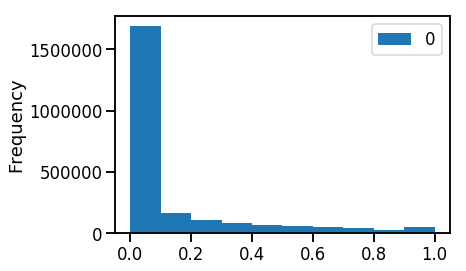

In [30]:
pd.DataFrame(y_test).plot.hist()

In [31]:
print('Test duplicates with >0.9 confidence:', len(df_submission[df_submission.is_duplicate > 0.9]))
print('Test mean prediction:', np.mean(y_test))
print('Calibrated mean prediction:', df_submission['is_duplicate'].mean())

Test duplicates with >0.9 confidence: 41721
Test mean prediction: 0.1285997052576751
Calibrated mean prediction: 0.07656442422713633


In [32]:
if not os.path.exists(project.submissions_dir):
    os.makedirs(project.submissions_dir)

In [33]:
df_submission.to_csv(
    project.submissions_dir + f'{submission_id}-submission-draft-cv-{final_cv_score:.6f}.csv',
    header=True,
    float_format='%.8f',
    index=None,
)